<a href="https://colab.research.google.com/github/Totti00/VA_Project/blob/main/VA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First commit

In [1]:
!wget https://www.dropbox.com/scl/fi/ybx2y1kvy99e2240gc9gg/san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn&dl=0
!unzip -q san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn
!rm san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn

--2024-02-18 13:59:27--  https://www.dropbox.com/scl/fi/ybx2y1kvy99e2240gc9gg/san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0df89968b9bbbedffd8829a7e.dl.dropboxusercontent.com/cd/0/inline/CNjq3Z29r1wSsCstaAbbW6B0oxqo25AmGFw1XE0p1QEbm_ZpWbgkrTbcC_LV4wecZf8h4KQiJT8u3zJ1xJKOXHeUIKYlG9-1Znp6U7WybT6WE62Fgn_3jhjUK5PQK4775c_lk8hmiZXNdJ_0D7k9jIos/file# [following]
--2024-02-18 13:59:29--  https://uca0df89968b9bbbedffd8829a7e.dl.dropboxusercontent.com/cd/0/inline/CNjq3Z29r1wSsCstaAbbW6B0oxqo25AmGFw1XE0p1QEbm_ZpWbgkrTbcC_LV4wecZf8h4KQiJT8u3zJ1xJKOXHeUIKYlG9-1Znp6U7WybT6WE62Fgn_3jhjUK5PQK4775c_lk8hmiZXNdJ_0D7k9jIos/file
Resolving uca0df89968b9bbbedffd8829a7e.dl.dropboxusercontent.com (uca0df89968b9bbbedffd8829a7e.dl.dropboxusercontent.com).

In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install uvicorn
!pip install python-multipart
!pip install kaleido
!pip install fastapi
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [1]:
import os
from PIL import Image
import math
import torch
from timeit import default_timer as timer
from datetime import timedelta
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import directed_hausdorff
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#import supervision as sv

def resize_img(img_path, input_size):
  my_image = plt.imread(img_path)
  print(my_image.shape)
  if max(my_image.shape[0], my_image.shape[1]) > input_size:
    if my_image.shape[0] >= my_image.shape[1]:
      height = input_size
      width = int(my_image.shape[1] * input_size / my_image.shape[0])
    else:
      width = input_size
      height = int(my_image.shape[0] * input_size / my_image.shape[1])
    my_image = cv2.resize(my_image, (width, height), interpolation=cv2.INTER_LINEAR)
  plt.imsave(img_path, my_image)

def pad_img(img_path, input_size):
  my_image = plt.imread(img_path)
  pad_width = input_size - my_image.shape[0]
  pad_height = input_size - my_image.shape[1]
  my_padded_image = np.pad(my_image, ((0, pad_width), (0, pad_height), (0, 0)), 'constant')
  plt.imsave(img_path, my_padded_image)

def crop_image(image):
  cropped_image = image[1000:, 1500:]
  cropped_image = cropped_image[:2400, :2600]
  return cropped_image

def sliding_window_hausdorff_distance(contoursA, contoursB, window_size):
  min_distance = float('inf')

  # Confronta l'array più piccolo con una porzione dell'array più grande
  for i in range(len(contoursB) - window_size + 1):
    window_contoursB = contoursB[i:i+window_size]

    # Calcola la distanza di Hausdorff diretta tra i contorni
    distance= directed_hausdorff(contoursA, window_contoursB)[0]

    # Aggiorna la minima distanza se necessario
    min_distance = min(min_distance, distance)

    # Ripeti il confronto con finestre di dimensioni ridotte
    for window_size in range(window_size - 1, 0, -1):
      for i in range(len(contoursB) - window_size + 1):
        window_contoursB = contoursB[i:i+window_size]

        # Calcola la distanza di Hausdorff diretta tra i contorni
        distance= directed_hausdorff(contoursA, window_contoursB)[0]

        # Aggiorna la minima distanza se necessario
        min_distance = min(min_distance, distance)

  return min_distance

#def match_edges(edge_1, edge_2):
#  min_distance = float('inf')
#  min_coords = None
#  edge_min = min((edge_1, edge_2), key=len)
#  edge_max = max((edge_1, edge_2), key=len)
#  len_max = len(edge_max)
#  for j in range(0, len(edge_min), 100):
#      len_min = len(edge_min) - j
#      for x in range(0, len_max - len_min, 60):
#          for y in range(0, len(edge_min) - len_min, 60):
#              distance = directed_hausdorff(edge_min[y:y+len_min], edge_max[x:x+len_min])[0]
#              if distance < min_distance:
#                    min_distance = distance
#                    min_coords = (x, x + len_min, y, y + len_min)
#  return min_distance, min_coords

def find_start(img):
  for x, line in enumerate(img):
    for y, col in enumerate(line):
      if col == 255:
        return (x, y)

def check_around(img, last, edge):
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(last[0]+i, img.shape[0]-1))
      y = max(0, min(last[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        return [x, y]
  return -1

def drow_edge(img, start):
  edge = np.array([[start[0], start[1]]])
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(start[0]+i, img.shape[0]-1))
      y = max(0, min(start[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        last = [x, y]
        edge = np.vstack((edge, last))
  while last != start:
    last = check_around(img, last, edge)
    if last == -1:
      last = check_around(img, edge[-2], edge)
      if last == -1:
        return edge
    else:
      edge = np.vstack((edge, [last[0], last[1]]))
  return edge


# Questo codice qui sotto controlla tutta la directory 6 e per ogni immagine calcola SAM e canny.
## Questo produce anche un array (array_contours) che contiene tutti gli array  dei bordi di tutte le immagini

In [4]:
#Serve per inizializzare il tutto
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=8)

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [5]:
folder_path = "/content/dataset/train/6"

# Elenco dei file nella cartella
file_list = os.listdir(folder_path)

#Array contenente gli array dei bordi di tutte le immagini
array_contours = []

# Apri tutte le immagini con OpenCV
images = []
for file_name in file_list:
  if file_name.endswith(('.png', '.jpg', '.jpeg')) and not file_name.startswith('gt') :
    nome_file = file_name.split('.')[0]
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)
    img = crop_image(image)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

    img = masks[1].astype('uint8') * 255 #serve per mapparla da booleano a scala di grigi
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    edges_D = cv2.Canny(blurred,0,100)
    prova = drow_edge(edges_D, find_start(edges_D))
    array_contours.append(prova)
    seg_edge = np.zeros((4016, 6016))
    x_coords, y_coords = prova[:, 0], prova[:, 1]
    seg_edge[x_coords, y_coords] = 255

    plt.imsave(os.path.join('dataset', 'train', '6', f'{nome_file}_sam_canny.png'), seg_edge)

In [ ]:
#QUESTO SERVE PER PLOTTARE LA FOTO SEGMENTATA MA NON SERVE FARLO
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=img.copy(), detections=detections)

sv.plot_images_grid(
    images=[img, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
#QUESTO SERVE PER PLOTTARE LE MASCHERE MA NON SERVE FARLO
masks = [mask['segmentation'] for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 2)),
    size=(16, 16)
)

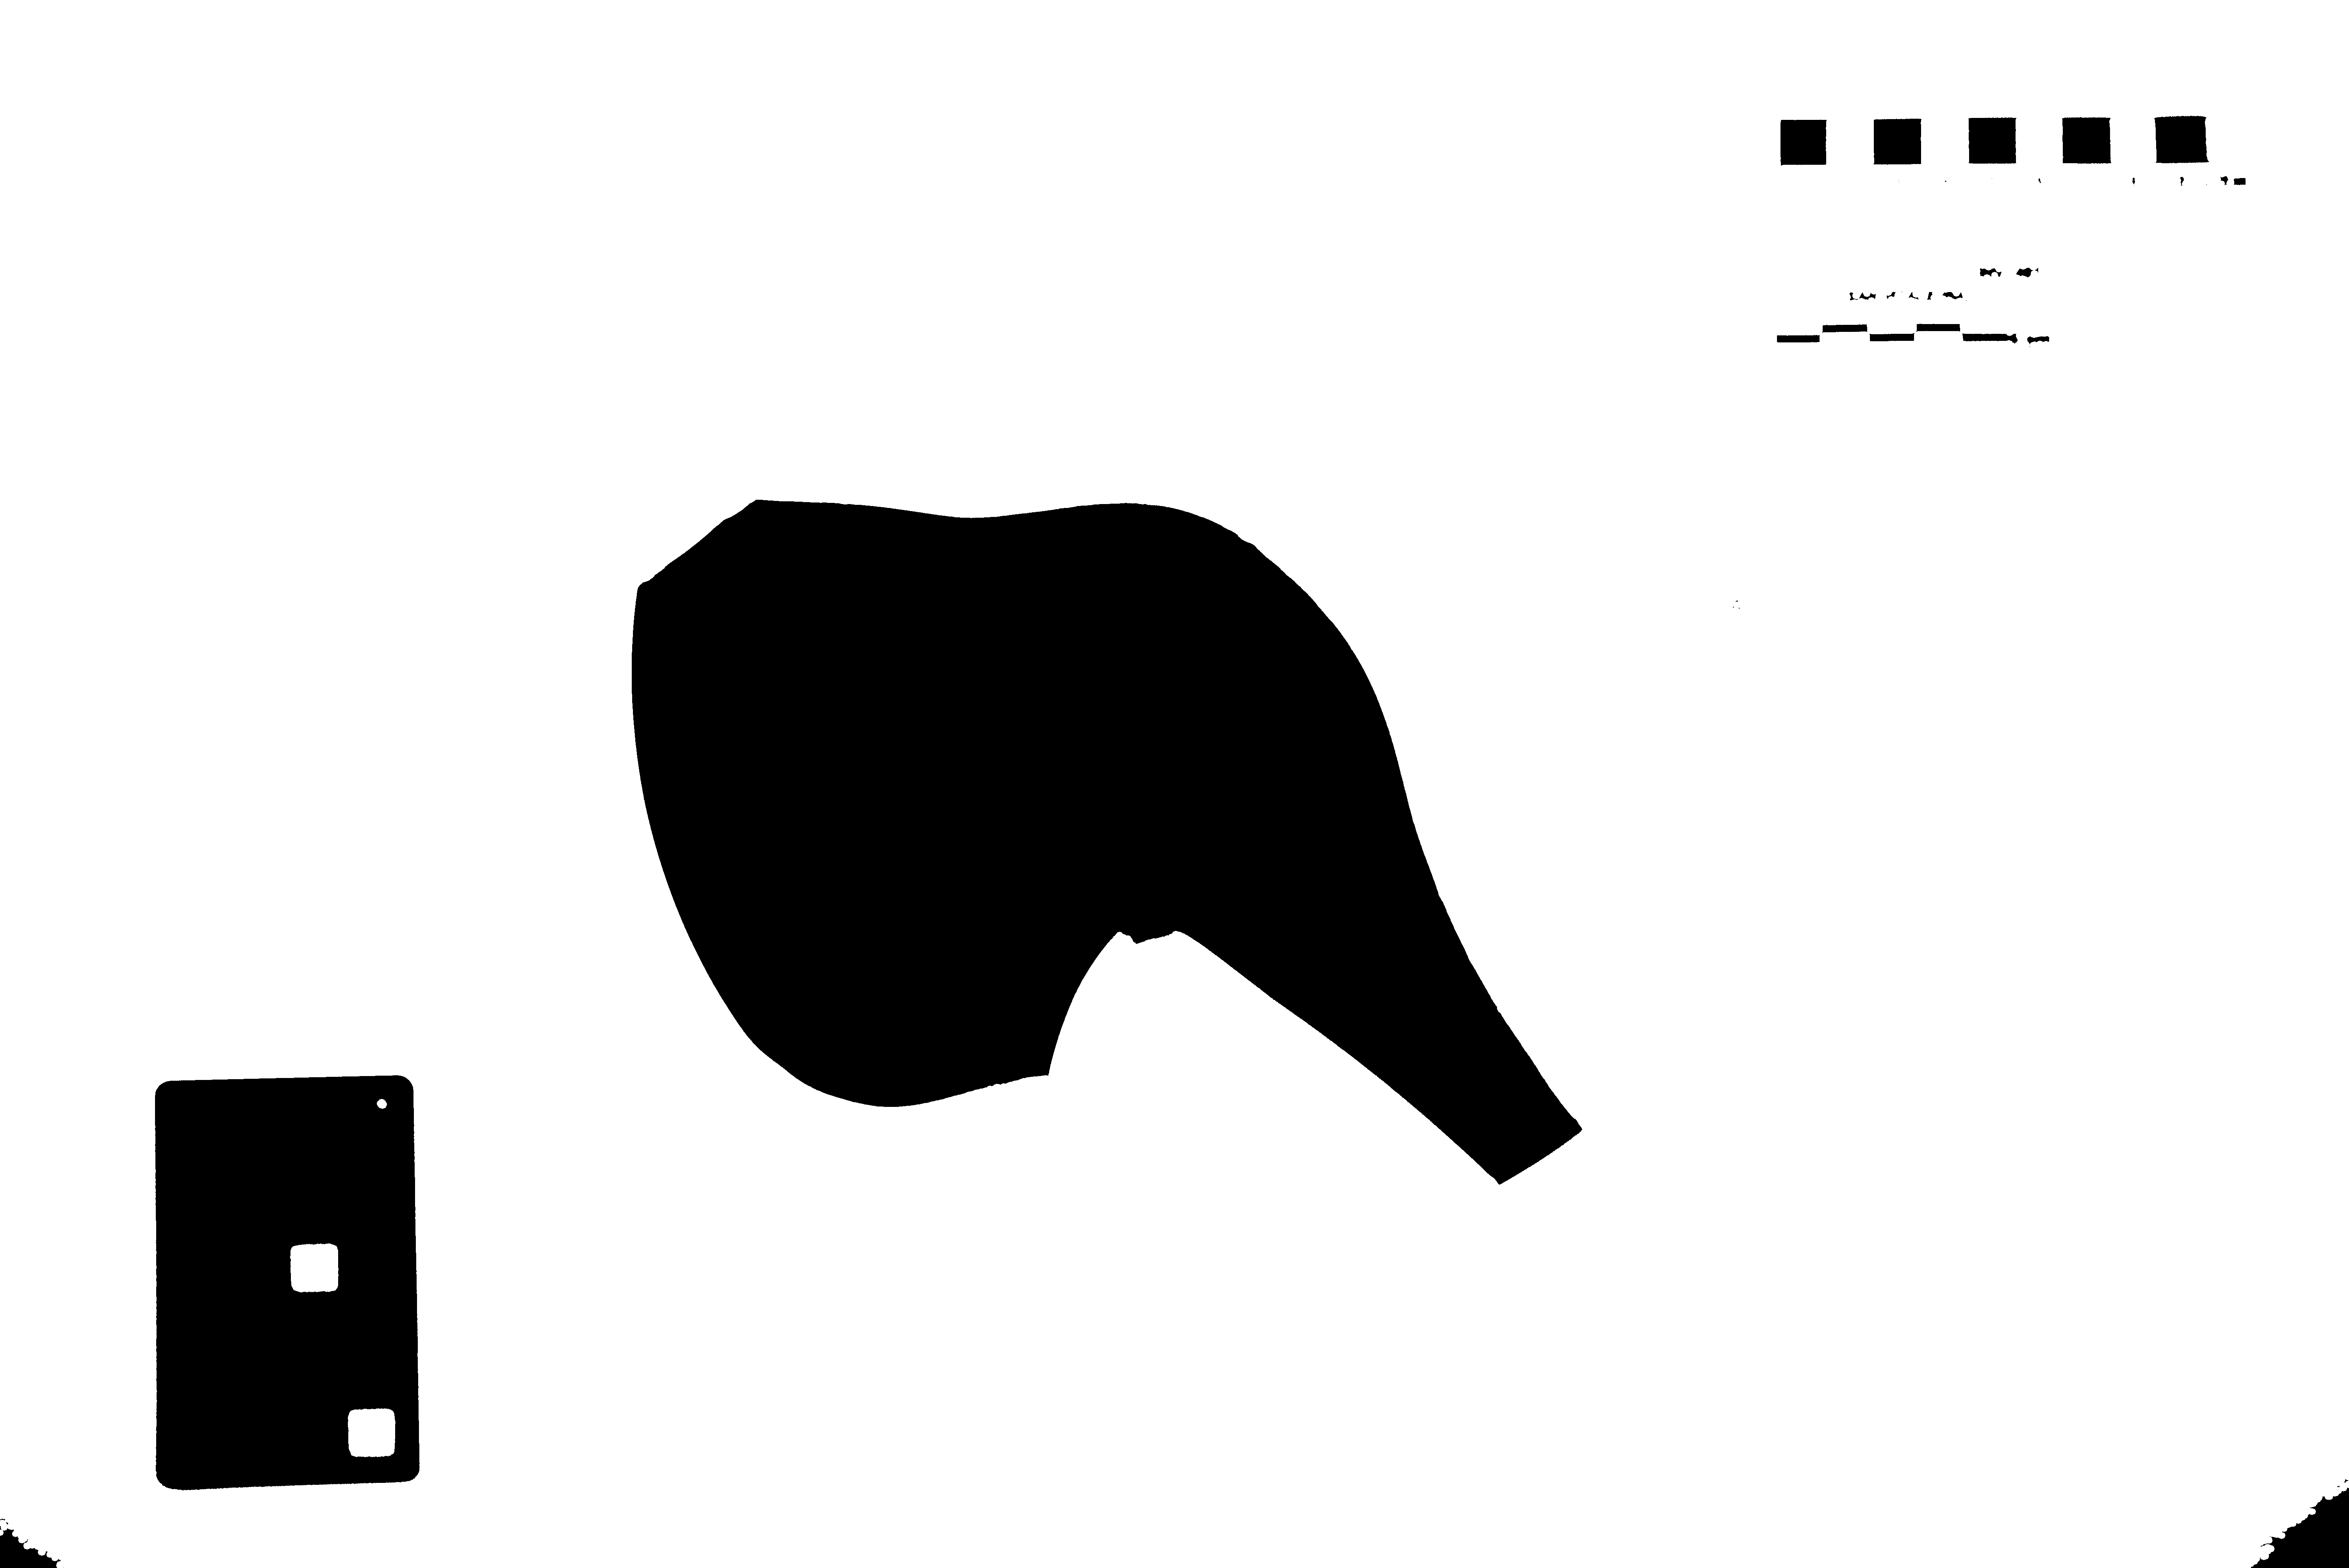

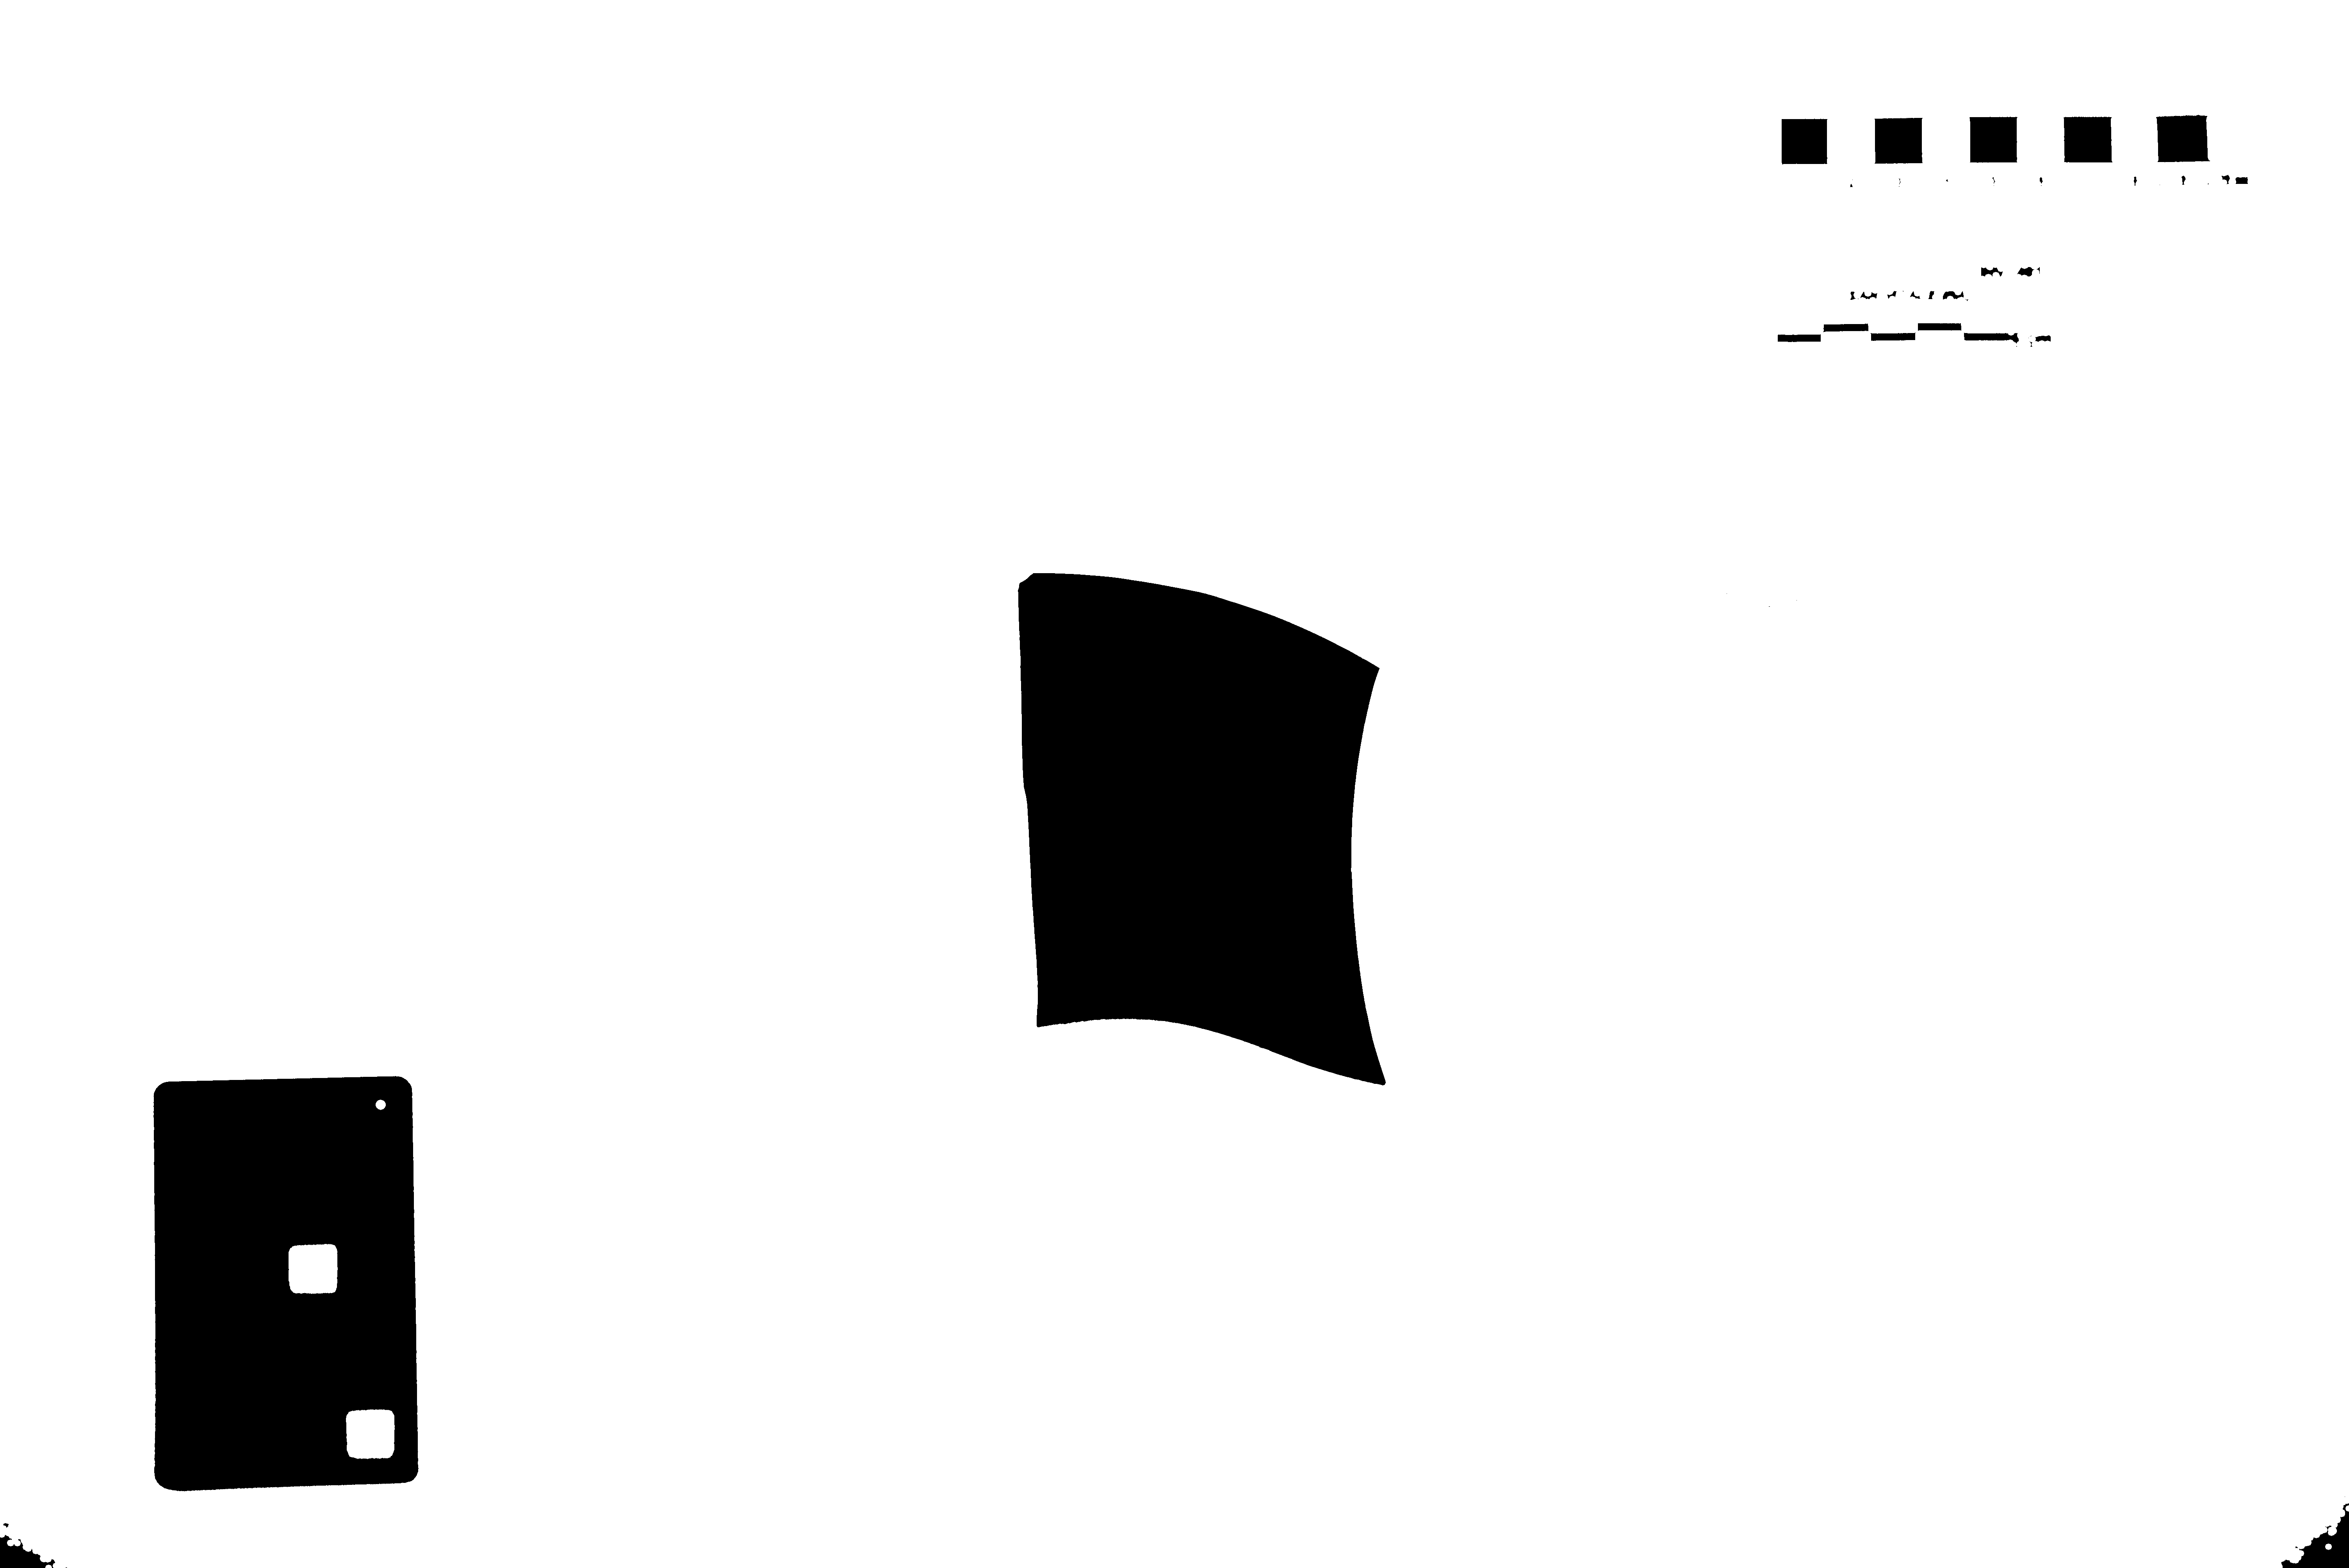

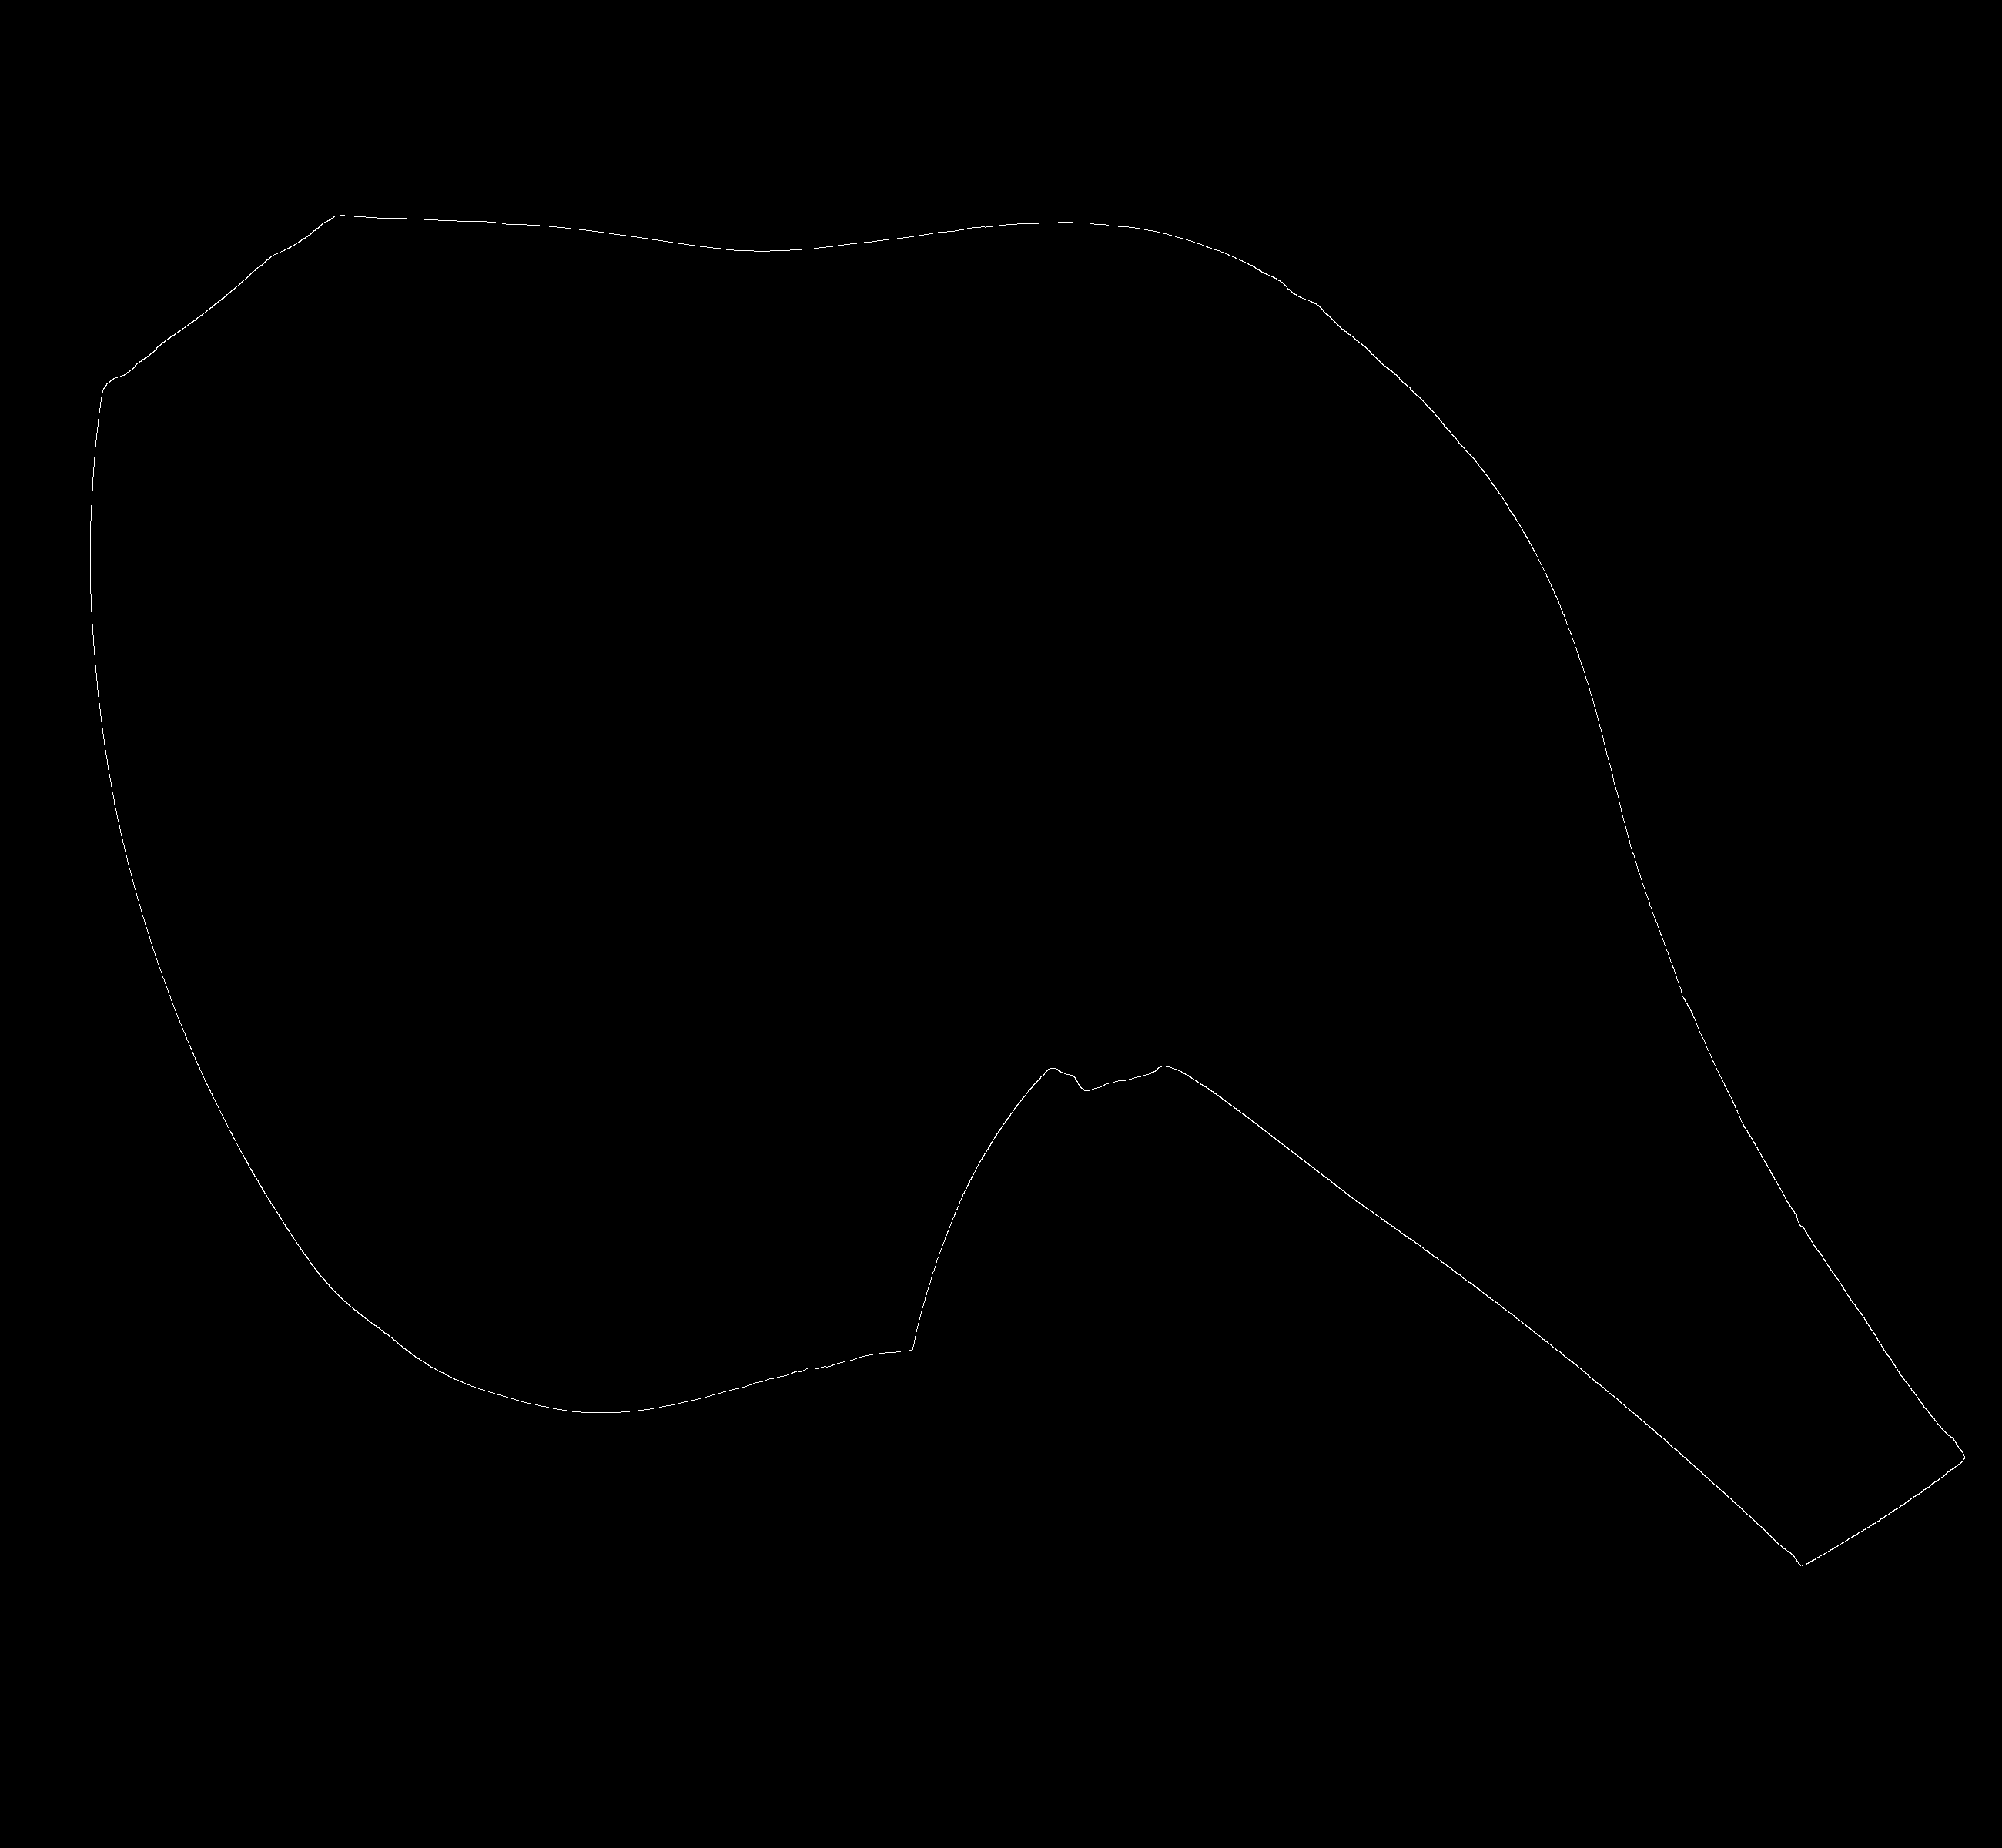

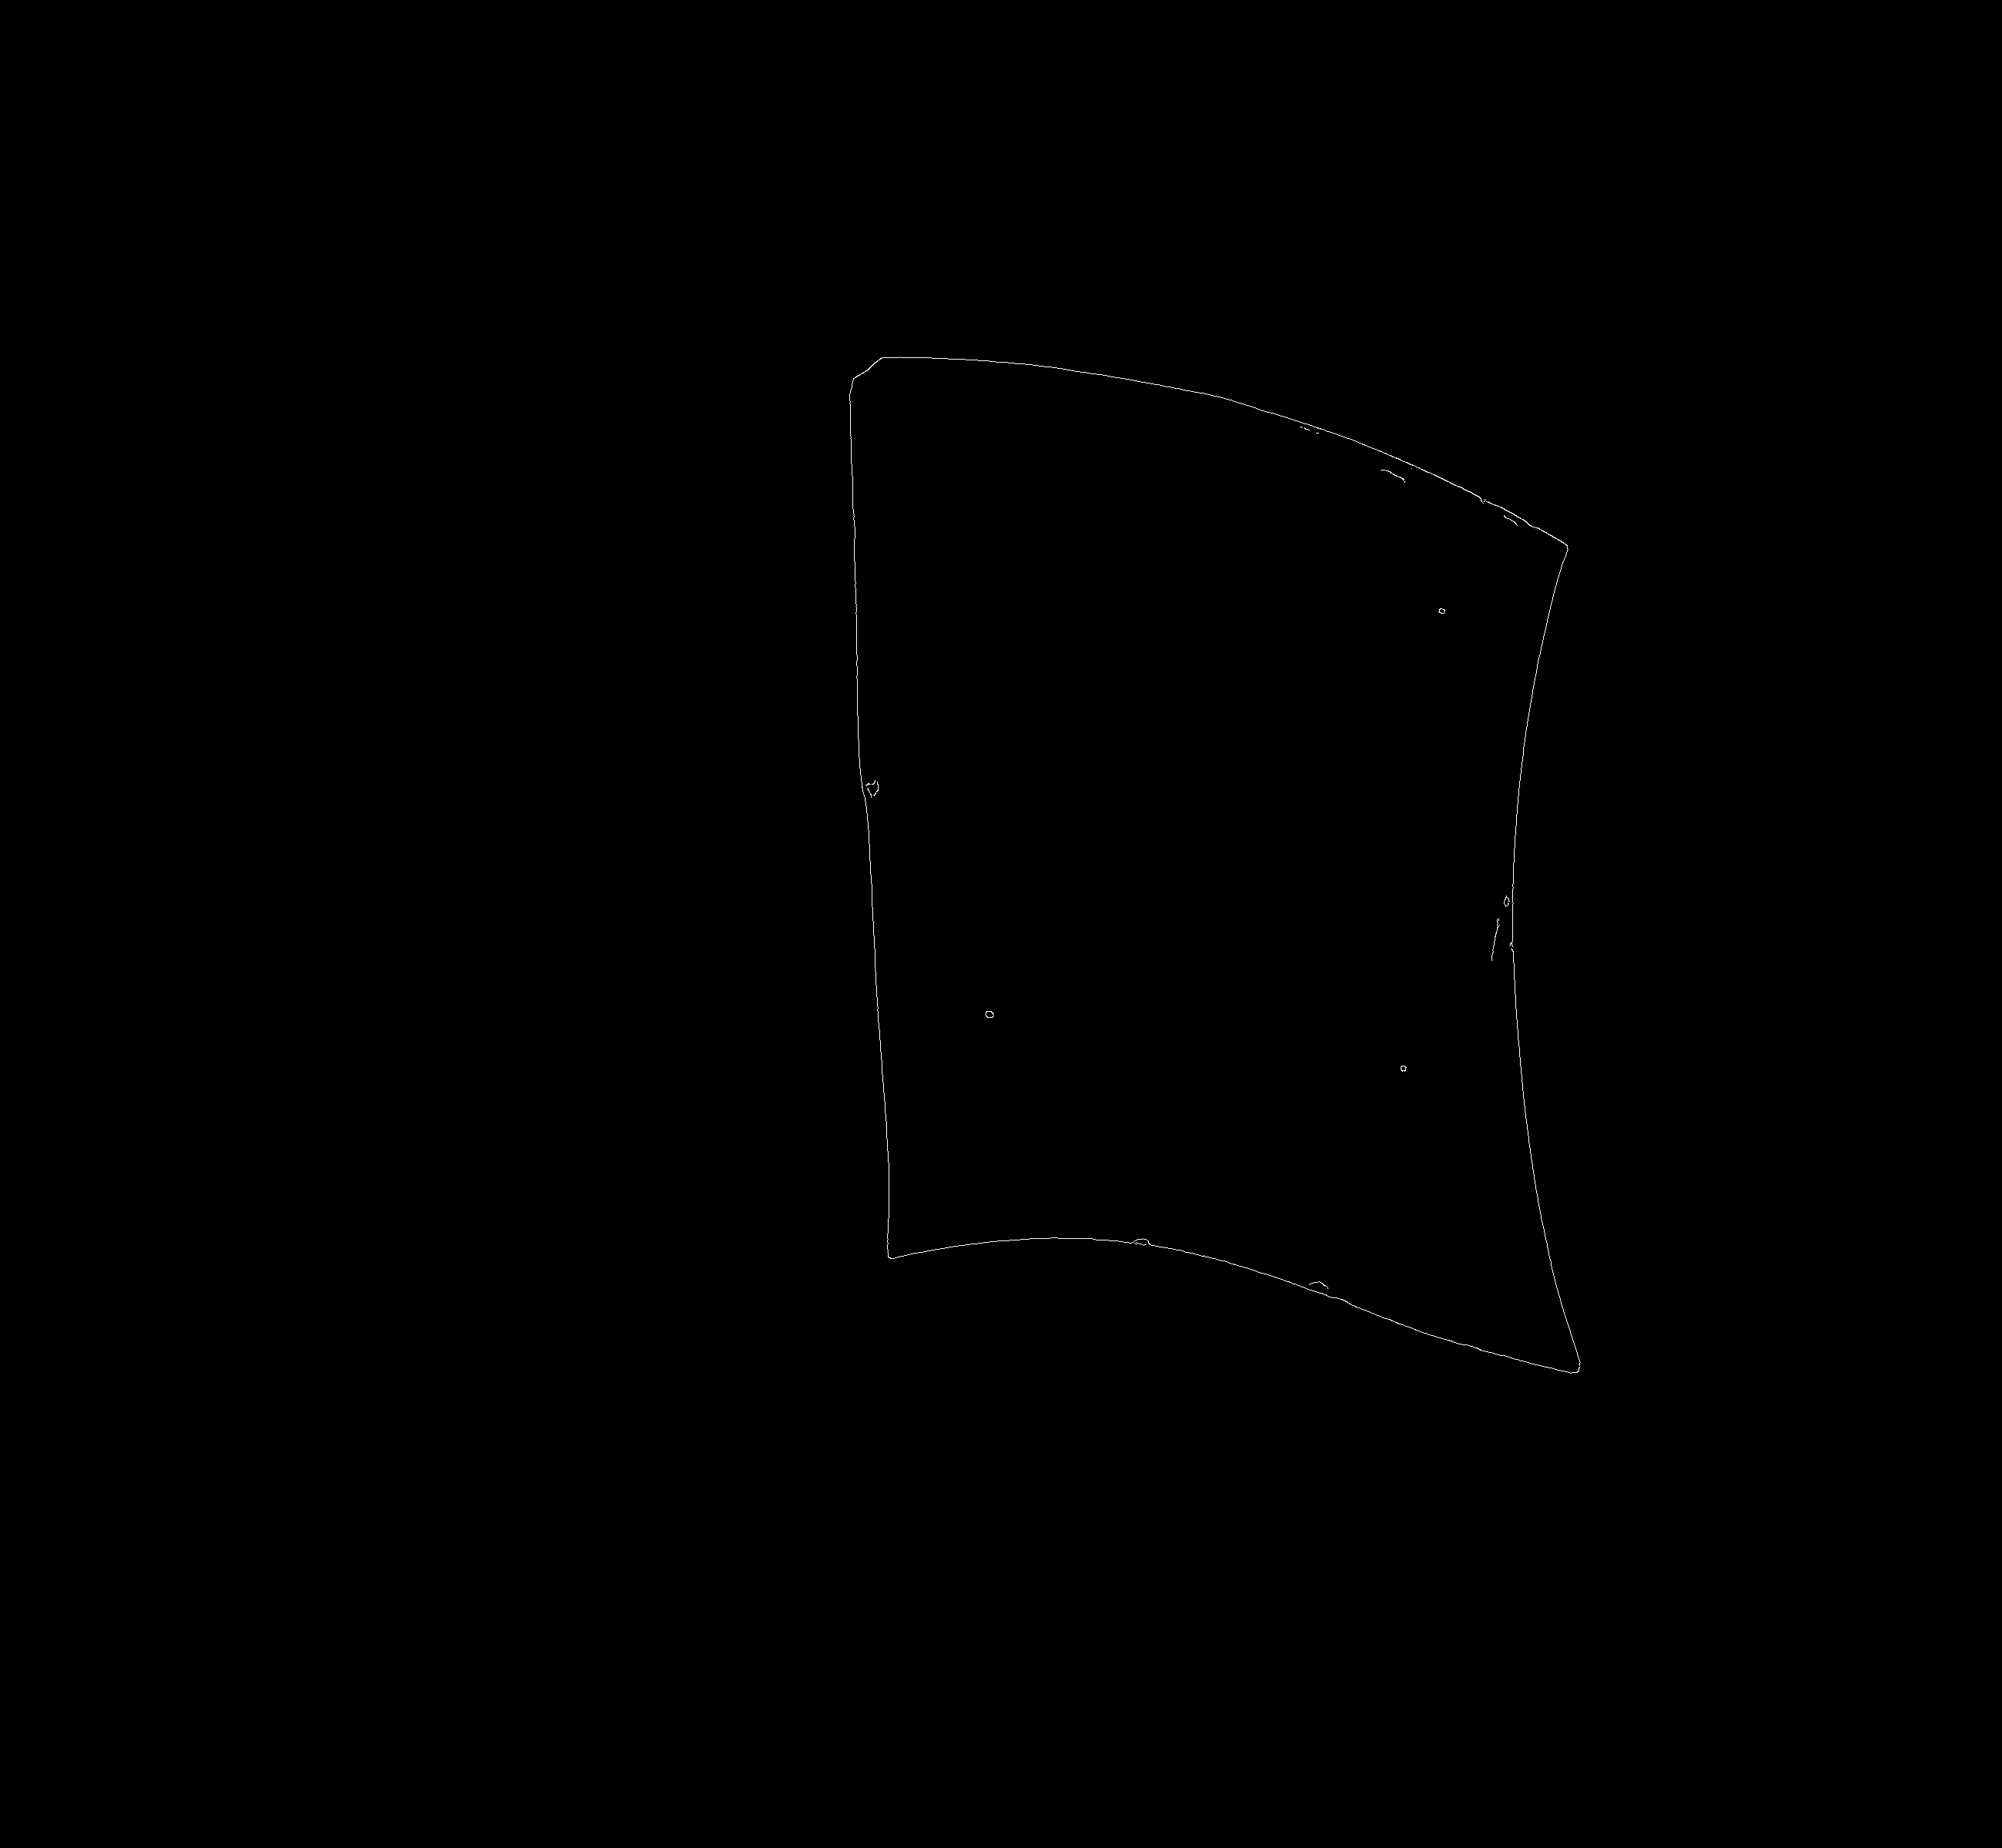

In [27]:
img_A = cv2.imread('/content/dataset/train/6/A.png', cv2.IMREAD_GRAYSCALE)
img_D = cv2.imread('/content/dataset/train/6/D.png', cv2.IMREAD_GRAYSCALE)

_, bwA = cv2.threshold(img_A, 140, 255, cv2.THRESH_BINARY)
_, bwD = cv2.threshold(img_D, 140, 255, cv2.THRESH_BINARY)
s = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

res1 = cv2.morphologyEx(bwA, cv2.MORPH_OPEN, s)
img_final_A = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_A = cv2.dilate(img_final_A, s)
cv2_imshow(img_final_A)

res1 = cv2.morphologyEx(bwD, cv2.MORPH_OPEN, s)
img_final_D = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_D = cv2.dilate(img_final_D, s)
cv2_imshow(img_final_D)

#res = img.copy()
#res[res2==0]=0

blurred = cv2.GaussianBlur(img_final_A, (13, 13), 0)
assert img_A is not None, "file could not be read, check with os.path.exists()"
edges_A = cv2.Canny(blurred,0,100)

blurred = cv2.GaussianBlur(img_D, (13, 13), 0)
assert img_D is not None, "file could not be read, check with os.path.exists()"
edges_D = cv2.Canny(blurred,0,100)

cropped_image_D = crop_image(edges_D)
cropped_image_A = crop_image(edges_A)
# Display cropped image
cv2_imshow(cropped_image_A)
cv2_imshow(cropped_image_D)

# Test

In [2]:
test_segment1 = np.array([[  0, 255, 255, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment2 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0, 255, 255, 255, 255,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment3 = np.array([[  0, 255, 255, 255, 255, 255, 255],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment4 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0]])

arr1 = drow_edge(test_segment1, find_start(test_segment1))
arr2 = drow_edge(test_segment2, find_start(test_segment2))
arr3 = drow_edge(test_segment3, find_start(test_segment3))
arr4 = drow_edge(test_segment4, find_start(test_segment4))

In [3]:
def check_euc_distance(arr1, arr2):
  quad_distance1X = (arr1[0][0] - arr1[-1][0])**2
  quad_distance1Y = (arr1[0][1] - arr1[-1][1])**2
  quad_distance1 = quad_distance1X + quad_distance1Y

  quad_distance2X = (arr2[0][0] - arr2[-1][0])**2
  quad_distance2Y = (arr2[0][1] - arr2[-1][1])**2
  quad_distance2 = quad_distance2X + quad_distance2Y
  return quad_distance1 == quad_distance2

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_angle(a, b, c):
  cosine_angle = get_cosine_angle(a, b, c)
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

def get_cosine_angle(a, b, c):
  ba = a - b
  bc = c - b
  return round(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)), 10)

def eval_match(edge1, edge2):
  arr1 = edge1.copy()
  arr2 = edge2.copy()
  if check_euc_distance(arr1, arr2):# and check_length(arr1, arr2):
    shift = arr1[0] - arr2[0]
    arr2 += shift
    arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    if (get_cosine_angle(arr1[-1], arr1[0], arr2[-1]) < 0):
      arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    arr2.astype('int64')
    return sliding_window_hausdorff_distance(arr1, arr2, 6) #TODO: al posto del 6 ci va la dimensione della sliding window
  else:
    return float('inf')

def match_edges(arr1, arr2, size):
  edge_1 = arr1.copy()
  edge_2 = arr2.copy()
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  #for j in range(0, len(edge_min), 100):
  #    len_min = len(edge_min) - j
  for x in range(0, len_max - size, 50):
      for y in range(0, len(edge_min) - size, 50):
          distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])
          if distance < min_distance:
                min_distance = distance
                min_coords = (x, x + size, y, y + size)
  return min_distance, min_coords

def check_length(arr1, arr2):
  # Calcola la lunghezza dei bordi e confronta le lunghezze con una tolleranza del 10%
    return abs(cv2.arcLength(arr1, True) - cv2.arcLength(arr2, True)) / max(cv2.arcLength(arr1, True), cv2.arcLength(arr2, True)) <= 0.2

In [4]:
arr1

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3]])

In [5]:
eval_match(arr2, arr1)

9.930136612989092e-16

In [6]:
check_length(arr1, arr2)

True

In [7]:
match_edges()

TypeError: match_edges() missing 3 required positional arguments: 'arr1', 'arr2', and 'size'

In [8]:
array_contours[3]

NameError: name 'array_contours' is not defined

In [38]:
match_edges(array_contours[0], array_contours[1], 150)

(54.20332093147061, (50, 200, 550, 700))

In [ ]:
seg_edge = np.zeros((4016, 6016))
x_coords, y_coords = array_contours[0][1800:1860], array_contours[1][840:900]
seg_edge[x_coords, y_coords] = 255

In [ ]:
seg_edge1 = np.zeros((200, 200))
seg_edge2 = np.zeros((200, 200))

shift = np.zeros([60, 2], dtype = int) - array_contours[0][1800:1860]
x_coords = array_contours[0][1800:1860] + shift

shift = np.zeros([60, 2], dtype = int) - array_contours[1][840:900]
y_coords = array_contours[1][840:900] + shift
seg_edge1[x_coords] = 255
cv2_imshow(seg_edge1)
seg_edge2[y_coords] = 255
cv2_imshow(seg_edge2)

IndexError: index 2680 is out of bounds for axis 0 with size 200

In [6]:
array_contours

[array([[280, 448],
        [280, 449],
        [281, 447],
        ...,
        [280, 452],
        [280, 451],
        [280, 450]]),
 array([[ 737, 1225],
        [ 737, 1226],
        [ 738, 1224],
        ...,
        [ 737, 1229],
        [ 737, 1228],
        [ 737, 1227]]),
 array([[ 467, 1154],
        [ 467, 1155],
        [ 468, 1153],
        ...,
        [ 467, 1158],
        [ 467, 1157],
        [ 467, 1156]]),
 array([[ 866, 1378],
        [ 866, 1379],
        [ 867, 1377],
        ...,
        [ 866, 1382],
        [ 866, 1381],
        [ 866, 1380]])]

In [8]:
for array in array_contours:
  np.savetxt("foo.csv", array, delimiter=",")

In [41]:
with open("contorni.txt", "w") as f:
  for array in array_contours:
      f.write("[")
      for elem in array:
	      f.write(str(elem))
      f.write("]")

TypeError: str() argument 'errors' must be str, not numpy.int64

In [54]:
with open("contorni.txt", "r") as f:
  contours = f.read()
contours = contours.replace("\n", "").split("]][[")

In [55]:
contours[0] = contours[0].split("][")

In [56]:
with open("contorni1.txt", "w") as f:
  for array in contours[0]:
      f.write("[")
      for elem in array:
	      f.write(str(elem))
      f.write("]")

In [57]:
len(contours[0])

7562

In [52]:
contours[0][1]

'280 449'

In [29]:
contours[0][0] = contours[0][0].strip("[")
contours[0][0]

'280 448'

In [8]:
contours[0][0] = contours[0][0].split(" ")
contours[0][0]

['[[280', '448']

In [ ]:
contours[0]

In [58]:
contours_array = np.array([])
for pixel in contours[0]:
  pixel = pixel.strip("[")
  pixel = pixel.strip("]")
  if "   " in pixel:
    pixel = pixel.split("   ")
  elif "  " in pixel:
    pixel = pixel.split("  ")
  else:
    pixel = pixel.split(" ")
  tmp = np.array(pixel)
  contours_array = np.concatenate((contours_array, tmp))
contours_array

array(['280', '448', '280', ..., '451', '280', '450'], dtype='<U32')

In [63]:
filtered_array = np.array([])
filtered_array[np.array([y.size>0 for y in contours_array])]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 16458

In [61]:
filtered_contours = np.delete(contours_array, np.where(contours_array == []))

ValueError: operands could not be broadcast together with shapes (16458,) (0,) 

In [59]:
with open("contorni2.txt", "w") as f:
  for array in contours_array:
      f.write("[")
      for elem in array:
	      f.write(str(elem))
      f.write("]")

In [62]:
len(contours_array)

16458

In [26]:
test = '1 2'
test = test.split("  ")

In [33]:
test = '1  2'
if "  " in test:
  print("doppio")
else:
  print("mono")

doppio


In [27]:
test

['1 2']

In [21]:
for elem in contours_array:
  print(elem)

Output streaming troncato alle ultime 5000 righe.

965
2085

964
2084

963
2084

962
2084

961
2084

960
2084

959
2083

958
2083

957
2083

956
2082

955
2082

954
2082

953
2081

952
2081

951
2081

950
2080

949
2079

948
2079

947
2079

946
2078

945
2078

944
2078

943
2077

942
2077

941
2076

940
2076

939
2076

938
2075

937
2075

936
2075

935
2074

934
2074

933
2074

932
2074

931
2074

930
2074

929
2073

928
2073

927
2073

926
2073

925
2073

924
2072

923
2072

922
2072

921
2072

920
2071

919
2071

918
2071

917
2070

916
2070

915
2070

914
2069

913
2069

912
2069

911
2068

910
2068

909
2068

908
2068

907
2067

906
2067

905
2067

904
2066

903
2066

902
2066

901
2066

900
2065

899
2065

898
2065

897
2065

896
2065

895
2064

894
2064

893
2064

892
2064

891
2064

890
2064

889
2063

888
2063

887
2063

886
2063

885
2062

884
2062

883
2062

882
2061

881
2061

880
2061

879
2060

878
2060

877
2059

876
2059

875
2058

874
2058

873
2057

872
2057

871
2056


In [70]:
len(contours_array)

35896

In [62]:
contours[0][0] = contours[0][0].strip("[")
contours[0][0] = contours[0][0].split(" ")
contours_array = np.array([contours[0][0][0], contours[0][0][1]])
print(contours_array)
for pixel in contours[0][1:]:
  pixel = pixel.strip("[")
  pixel = pixel.strip("]")
  pixel = pixel.split(" ")
  tmp = np.array(pixel)
  contours_array = np.concatenate((contours_array, tmp))
contours_array

['280' '448']


array(['280', '448', '280', ..., '451', '280', '450'], dtype='<U4')

In [ ]:
len(contours_array)

In [64]:
contours_array[0]

'280'

In [ ]:
contours[0]

In [ ]:
contours

In [73]:
lista = (1, 2, 3, 4, 5)
prova = np.array([])
for i in lista:
  prova = np.concatenate((prova, i))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [44]:
import numpy as np

# Read the text file
file_path = 'contorni.txt'
with open(file_path, 'r') as file:
    content = file.read()

# Extract numerical values
values_str = content.replace('[', '').replace(']', '').replace('\n', '').split(' ')
values = [list(map(int, value.split())) for value in values_str if value]

# Convert to NumPy array
array = np.array(values)

# Print or use the array as needed
print(array)

[[   280]
 [448280]
 [449281]
 ...
 [  1381]
 [   866]
 [  1380]]


In [46]:
len(array)

21528